In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from pprint import pprint

# hiperparametry
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'discount_factor': [0.9, 0.99, 0.999],
    'epsilon_start': [1.0, 0.8],
    'epsilon_min': [0.1, 0.05],
    'epsilon_decay': [0.995, 0.99]
}

# ocena algorytmu Q-learning
def qlearning_eval(learning_rate, discount_factor, epsilon_start, epsilon_min, epsilon_decay, episodes=1000, max_steps=100):
    env = gym.make("CliffWalking-v0")
    state_size = env.observation_space.n
    action_size = env.action_space.n
    Q = np.zeros((state_size, action_size))

    rewards_qlearning = []
    epsilon = epsilon_start

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = env.step(action)

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += learning_rate * td_error

            state = next_state
            total_reward += reward

            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_qlearning.append(total_reward)

    return np.sum(rewards_qlearning[:1000])  # nagroda w pierwszych 1000 epizodach

# ocena algorytmu Deep Q-Network
def dqn_eval(learning_rate, discount_factor, epsilon_start, epsilon_min, epsilon_decay, episodes=1000, max_steps=100):
    env = gym.make("CliffWalking-v0")
    state_size = env.observation_space.n
    action_size = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class QNetwork(nn.Module):
        def __init__(self, state_size, action_size):
            super(QNetwork, self).__init__()
            self.fc1 = nn.Linear(state_size, 64)
            self.fc2 = nn.Linear(64, action_size)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return self.fc2(x)

    q_network = QNetwork(state_size, action_size).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    epsilon = epsilon_start
    rewards_dqn = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.eye(state_size)[state].to(device)
        total_reward = 0

        for step in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_network(state)
                    action = torch.argmax(q_values).item()

            next_state, reward, done, truncated, _ = env.step(action)
            next_state_one_hot = torch.eye(state_size)[next_state].to(device)

            with torch.no_grad():
                target_q = reward + discount_factor * torch.max(q_network(next_state_one_hot))

            predicted_q = q_network(state)[action]
            loss = loss_fn(predicted_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state_one_hot
            total_reward += reward

            if done or truncated:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_dqn.append(total_reward)

    return np.sum(rewards_dqn[:1000])  # nagroda w pierwszych 1000 epizodach

best_qlearning_params = None
best_dqn_params = None
best_qlearning_score = -float('inf')
best_dqn_score = -float('inf')

# q-learning
for params in ParameterGrid(param_grid):
    score = qlearning_eval(**params)
    if score > best_qlearning_score:
        best_qlearning_score = score
        best_qlearning_params = params

# DQN
for params in ParameterGrid(param_grid):
    score = dqn_eval(**params)
    if score > best_dqn_score:
        best_dqn_score = score
        best_dqn_params = params

print("Hiperparameters")
pprint(list(ParameterGrid(param_grid)))

# wyniki optymalizacji
print(f"Najlepsze parametry dla Q-learning: {best_qlearning_params}, wynik: {best_qlearning_score}")
print(f"Najlepsze parametry dla DQN: {best_dqn_params}, wynik: {best_dqn_score}")


Hiperparameters
[{'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 1.0,
  'learning_rate': 0.01},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 1.0,
  'learning_rate': 0.1},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 1.0,
  'learning_rate': 0.5},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 0.8,
  'learning_rate': 0.01},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 0.8,
  'learning_rate': 0.1},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.1,
  'epsilon_start': 0.8,
  'learning_rate': 0.5},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.05,
  'epsilon_start': 1.0,
  'learning_rate': 0.01},
 {'discount_factor': 0.9,
  'epsilon_decay': 0.995,
  'epsilon_min': 0.05,
  'epsilon_start': 1.0,
  'learning_rate': 0

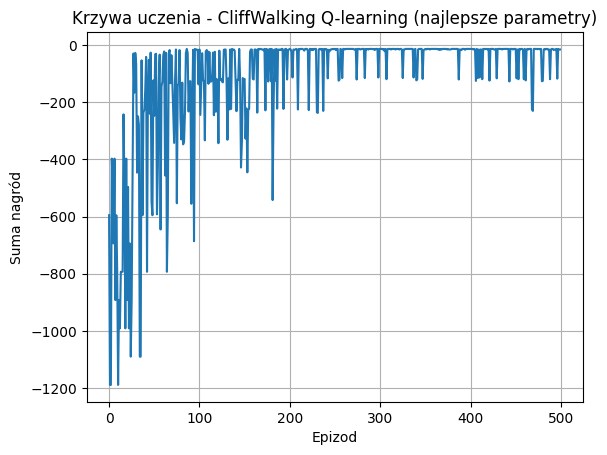

In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CliffWalking-v0")

# najlepsze hiperparametry
learning_rate = 0.5
discount_factor = 0.99
epsilon = 0.8
epsilon_min = 0.05
epsilon_decay = 0.99
episodes = 500
max_steps = 100

state_size = env.observation_space.n
action_size = env.action_space.n
Q = np.zeros((state_size, action_size))

rewards_qlearning = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_state, reward, done, truncated, _ = env.step(action)

        best_next_action = np.argmax(Q[next_state])
        td_target = reward + discount_factor * Q[next_state][best_next_action]
        Q[state][action] += learning_rate * (td_target - Q[state][action])

        state = next_state
        total_reward += reward

        if done or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_qlearning.append(total_reward)

env.close()

# wykres
plt.plot(rewards_qlearning)
plt.xlabel("Epizod")
plt.ylabel("Suma nagród")
plt.title("Krzywa uczenia - CliffWalking Q-learning (najlepsze parametry)")
plt.grid(True)
plt.show()

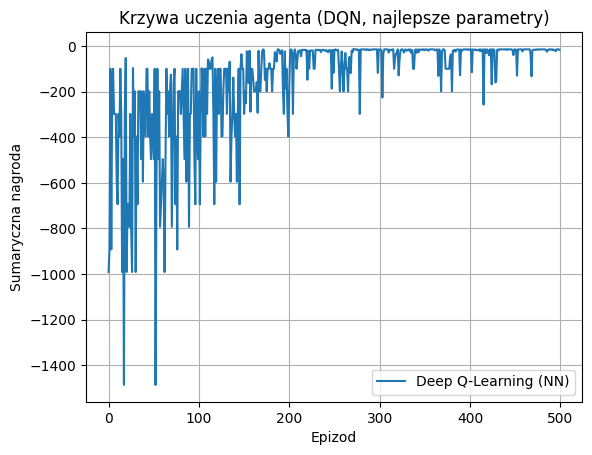

In [8]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # warstwa ukryta
        self.fc2 = nn.Linear(64, action_size)  # wyjście - wartości Q dla każdej akcji

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# najlepsze hiperparametry
learning_rate = 0.01
discount_factor = 0.999
epsilon = 0.8
epsilon_min = 0.05
epsilon_decay = 0.99
num_episodes = 500
max_steps = 100

env = gym.make("CliffWalking-v0")

state_size = env.observation_space.n
action_size = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_network = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

rewards_dqn = []

# trenowanie
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.eye(state_size)[state].to(device)
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_network(state)
                action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state_one_hot = torch.eye(state_size)[next_state].to(device)

        with torch.no_grad():
            target_q = reward + discount_factor * torch.max(q_network(next_state_one_hot))

        predicted_q = q_network(state)[action]
        loss = loss_fn(predicted_q, target_q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state_one_hot
        total_reward += reward

        if done or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)

env.close()

# wykres
plt.plot(rewards_dqn, label="Deep Q-Learning (NN)")
plt.xlabel("Epizod")
plt.ylabel("Sumaryczna nagroda")
plt.title("Krzywa uczenia agenta (DQN, najlepsze parametry)")
plt.grid(True)
plt.legend()
plt.show()

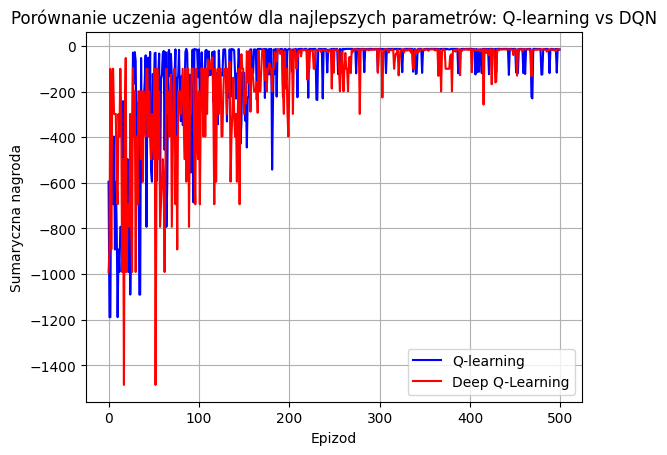

In [10]:
plt.plot(rewards_qlearning, label="Q-learning", color="blue")
plt.plot(rewards_dqn, label="Deep Q-Learning", color="red")
plt.xlabel("Epizod")
plt.ylabel("Sumaryczna nagroda")
plt.title("Porównanie uczenia agentów dla najlepszych parametrów: Q-learning vs DQN")
plt.grid(True)
plt.legend()
plt.show()